In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import pygmt as pygmt
import geopandas as gpd 

In [2]:
PATH_EARTH = os.path.join("tectonic_settings_Earth")

PATH_VENUS = os.path.join("../tectonic_settings_Venus")

EARTH_ZONES = gpd.read_file(f"{PATH_EARTH}/all_tectonic_settings.shp")

OC_POL = gpd.read_file(f"{PATH_EARTH}/continental_crust_polygons.shp")

VENUS_CORONA = gpd.read_file(f"{PATH_VENUS}/corona.shp")
VENUS_RIFTS = gpd.read_file(f"{PATH_VENUS}/rifts.shp")
VENUS_RIDGES = gpd.read_file(f"{PATH_VENUS}/ridges.shp")

CORONA_TOTAREA = VENUS_CORONA['Area_julia'].sum()
RIFTS_TOTAREA = VENUS_RIFTS['Area_julia'].sum()
RIDGES_TOTAREA = VENUS_RIDGES['Area_julia'].sum()


In [3]:
VENUS_SURFAREA = 460234317 #km2

print(f"Area rifts:{RIFTS_TOTAREA}km2 = {round(RIFTS_TOTAREA/VENUS_SURFAREA*100,2)}% of total area")
print(f"Area coronae:{CORONA_TOTAREA}km2 = {round(CORONA_TOTAREA/VENUS_SURFAREA*100,2)}% of total area")
print(f"Area ridges:{RIDGES_TOTAREA}km2 = {round(RIDGES_TOTAREA/VENUS_SURFAREA*100,2)}% of total area")

Area rifts:37967130.85050429km2 = 8.25% of total area
Area coronae:35718832.78818725km2 = 7.76% of total area
Area ridges:7568096.239942103km2 = 1.64% of total area


In [4]:
PATH_DATA = os.path.join("earthquake_data")

quakes_cmt = pd.read_csv(f"{PATH_DATA}/cmt_2020.csv")

# CMT categorized by tectonic setting
settings = ["collision", "subduction", "rifts", "spreading", "transform", "intraplate-oceanic", "intraplate-continental"]

quakes_tec = {}
for i, k in enumerate(settings):
    quakes_tec[k] = pd.read_csv(f"{PATH_DATA}/quakes-{k}.csv")


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
for type in quakes_tec:
    quakes_tec[type]['X'] = 'X'
    quakes_tec[type]['Y'] = 'Y'
    quakes_tec[type]['id'] = quakes_tec[type].index.tolist()
    quakes_tec[type].sample(frac=0.2)[['Longitude', 'Latitude', 'Depth', 'Mrr', 'Mtt', 'Mpp', 'Mrt', 'Mrp', 'Mtp', 'MS', 'X', 'Y', 'id']].to_csv(f'/staff/quentin/Documents/Codes/FMC-master/{type}_FMC.dat', header=None, index=False, sep = ' ')
    os.chdir('/staff/quentin/Documents/Codes/FMC-master/')
    template_FMC = f"./FMC.py -p '{type}.png' {type}_FMC.dat -pc fclvd"
    os.system(template_FMC)

In [7]:
import functionsFMC
import plotFMC
from tqdm import tqdm

type = 'collision'
row = 0
cols = ['Longitude', 'Latitude', 'Depth', 'Mrr', 'Mtt', 'Mpp', 'Mrt', 'Mrp', 'Mtp', 'MS', 'X', 'Y', 'id']

quakes_tec[type][['x_kav', 'y_kav']] = 0., 0.
for type in quakes_tec:
    print(f'Processing {type}')
    for _, data_pd in tqdm(quakes_tec[type][cols].iterrows(), total=quakes_tec[type][cols].shape[0]):

        data = [data_pd.values]
        expo = (data[row][9] * 1.0)
        mrr = data[row][3] * 10**expo
        mtt = data[row][4] * 10**expo
        mff = data[row][5] * 10**expo
        mrt = data[row][6] * 10**expo
        mrf = data[row][7] * 10**expo
        mtf = data[row][8] * 10**expo
        am = np.asarray(([mtt, -mtf, mrt], [-mtf, mff, -mrf], [mrt, -mrf, mrr]))

        # scalar moment and fclvd
        Mo, fclvd, val, vect, iso, u_Hudson, v_Hudson, fiso = functionsFMC.moment(am) # modified to return eigenvalues

        # Axis vectors
        px = vect[0, 0]
        py = vect[1, 0]
        pz = vect[2, 0]
        tx = vect[0, 2]
        ty = vect[1, 2]
        tz = vect[2, 2]
        bx = vect[0, 1]
        by = vect[1, 1]
        bz = vect[2, 1]

        # Axis trend and plunge
        trendp, plungp = functionsFMC.ca2ax(px, py, pz)
        trendt, plungt = functionsFMC.ca2ax(tx, ty, tz)
        trendb, plungb = functionsFMC.ca2ax(bx, by, bz)

        x_kav, y_kav = functionsFMC.kave(plungt, plungb, plungp)
        quakes_tec[type].loc[quakes_tec[type].index==data_pd.name, 'x_kav'] = x_kav
        quakes_tec[type].loc[quakes_tec[type].index==data_pd.name, 'y_kav'] = y_kav
        quakes_tec[type].loc[quakes_tec[type].index==data_pd.name, 'plungp'] = plungp
        quakes_tec[type].loc[quakes_tec[type].index==data_pd.name, 'plungt'] = plungt
        quakes_tec[type].loc[quakes_tec[type].index==data_pd.name, 'plungb'] = plungb

Processing collision


100%|██████████| 2517/2517 [00:07<00:00, 345.15it/s]


Processing subduction


100%|██████████| 38218/38218 [02:49<00:00, 225.31it/s]


Processing rifts


100%|██████████| 1022/1022 [00:02<00:00, 355.24it/s]


Processing spreading


100%|██████████| 10851/10851 [00:42<00:00, 252.59it/s]


Processing transform


100%|██████████| 2649/2649 [00:07<00:00, 358.85it/s]


Processing intraplate-oceanic


100%|██████████| 724/724 [00:01<00:00, 363.25it/s]


Processing intraplate-continental


100%|██████████| 859/859 [00:02<00:00, 364.63it/s]


In [13]:
quakes_tec_df = pd.DataFrame()
for type_quake in quakes_tec:
    data = quakes_tec[type_quake].copy()
    data['type_tectonic'] = type_quake
    quakes_tec_df = quakes_tec_df.append(data)
quakes_tec_df.reset_index(drop=True, inplace=True)
quakes_tec_df.to_csv('../../../quakes_earth_w_plunge.csv', header=True, index=False)

In [38]:
from sklearn.neighbors import KernelDensity

def sample_events(quakes_tec, number_per_type=10, l_types=[], min_ms=6, sample_new_events=False):

    new_quakes = pd.DataFrame()
    for type, quakes_tec_type in quakes_tec.groupby('type_tectonic'):
        
        ## Skip tectonic types that are not requested
        if (not type in l_types) and l_types: 
            continue
            
        number_this_type = number_per_type
        if isinstance(number_per_type, dict):
            number_this_type = number_per_type[type]
            
        data = quakes_tec_type.loc[quakes_tec_type.MS>=min_ms, ['plungp', 'plungt', 'plungb', 'MS']].values
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)

        if not sample_new_events:
            proba = np.exp(kde.score_samples(data))
            proba /= np.sum(proba)
            id_selected = np.random.choice(np.arange(data.shape[0]), p=proba, size=number_this_type)
            new_quakes_loc = quakes_tec_type.iloc[id_selected]
            new_quakes_loc.loc[:, 'tectonic_type'] = type
            new_quakes = new_quakes.append(new_quakes_loc)

        else:
            new_plunges = kde.sample(n_samples=100)
            for plungp, plungt, plungb, ms in new_plunges:
                strika, dipa, rakea, dipdira, strikb, dipb, rakeb, dipdirb = functionsFMC.pt2pl(trendp, plungp, trendt, plungt)
                x_kav, y_kav = functionsFMC.kave(plungt, plungb, plungp)
                new_quakes = new_quakes.append([{'ms': ms, 'strike': strika, 'dip': dipa, 'rake': rakea, 'plungp': plungp, 'plungt': plungt, 'plungb': plungb, 'trendp': trendp, 'trendt': trendt, 'x_kav': x_kav, 'y_kav': y_kav, 'type': type}])

                """
                px, py, pz = functionsFMC.ax2ca(trendp, plungp)
                tx, ty, tz = functionsFMC.ax2ca(trendt, plungt)
                bx, by, bz = functionsFMC.ax2ca(trendb, plungb)

                vect = np.zeros((3,3))
                vect[0, 0] = px
                vect[1, 0] = py
                vect[2, 0] = pz
                vect[0, 2] = tx
                vect[1, 2] = ty
                vect[2, 2] = tz
                vect[0, 1] = bx
                vect[1, 1] = by
                vect[2, 1] = bz
                """
        new_quakes.reset_index(drop=True, inplace=True)
    return new_quakes
        
quakes_tec_df = pd.read_csv('/staff/quentin/Documents/Projects/2023_Celine_internship/Venus_data/quakes_earth_w_plunge.csv', header=[0])
new_quakes = sample_events(quakes_tec_df, number_per_type=10, l_types=[], min_ms=6, sample_new_events=False)
new_quakes

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Year,Month,Day,Time,Latitude,Longitude,Depth,mb,MS,Region,...,X,Y,id,x_kav,y_kav,plungp,plungt,plungb,type_tectonic,tectonic_type
0,1978,7,31,11:55:40.0,35.47,82.00,33.0,5.0,5.4,"SOSINKIANGPROV,CHINA",...,X,Y,56,-0.254005,-0.177543,5.300342e+01,26.346131,2.397973e+01,collision,collision
1,1976,4,22,17:03:07.9,28.71,52.13,24.0,6.0,5.5,SOUTHERNIRAN,...,X,Y,0,0.717222,-0.386976,3.827753e+00,83.233769,5.571106e+00,collision,collision
2,1981,2,23,04:06:39.5,41.79,45.98,33.0,5.1,4.7,EASTERNCAUCASUS,...,X,Y,142,0.339055,-0.092922,2.005984e+01,54.590505,2.783864e+01,collision,collision
3,1983,5,28,11:35:53.8,32.58,48.55,33.0,5.6,5.0,WESTERNIRAN,...,X,Y,195,0.598644,-0.274186,9.101448e+00,73.255127,1.393391e+01,collision,collision
4,1980,5,4,18:35:20.0,38.05,48.99,46.0,5.4,6.2,CASPIANSEA,...,X,Y,104,0.085406,-0.602176,4.033306e+01,49.666663,1.247937e-01,collision,collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1982,3,25,05:05:39.1,-52.87,-46.93,10.0,5.9,6.1,SOUTHATLANTICOCEAN,...,X,Y,152,0.040756,0.673146,9.219447e+00,12.384944,7.447177e+01,transform,transform
66,1978,11,13,07:43:18.0,19.84,-76.05,33.0,5.1,4.7,CUBAREGION,...,X,Y,46,0.361058,-0.307610,2.272931e+01,61.936074,1.556938e+01,transform,transform
67,1980,1,1,16:42:40.0,38.82,-27.78,10.0,6.0,6.7,AZORESISLANDS,...,X,Y,83,-0.147749,0.537549,2.216104e+01,10.168533,6.538741e+01,transform,transform
68,1983,7,25,22:31:40.8,36.22,-120.39,8.0,5.6,5.3,CENTRALCALIFORNIA,...,X,Y,200,0.796225,-0.459701,2.017565e-11,90.000000,6.777563e-11,transform,transform


In [39]:
quakes_tec_df.type_tectonic.unique()

array(['collision', 'subduction', 'rifts', 'spreading', 'transform',
       'intraplate-oceanic', 'intraplate-continental'], dtype=object)

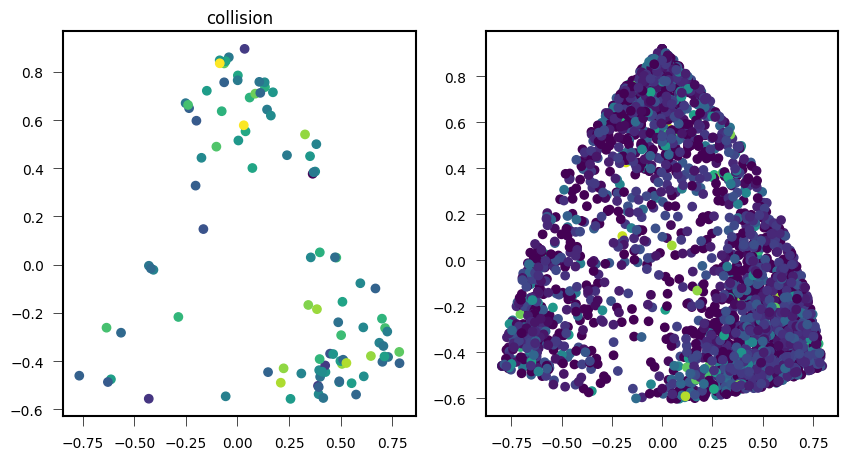

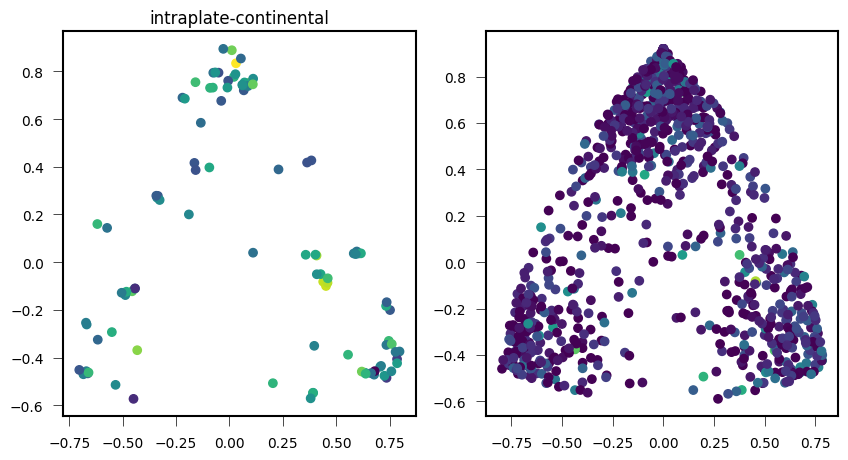

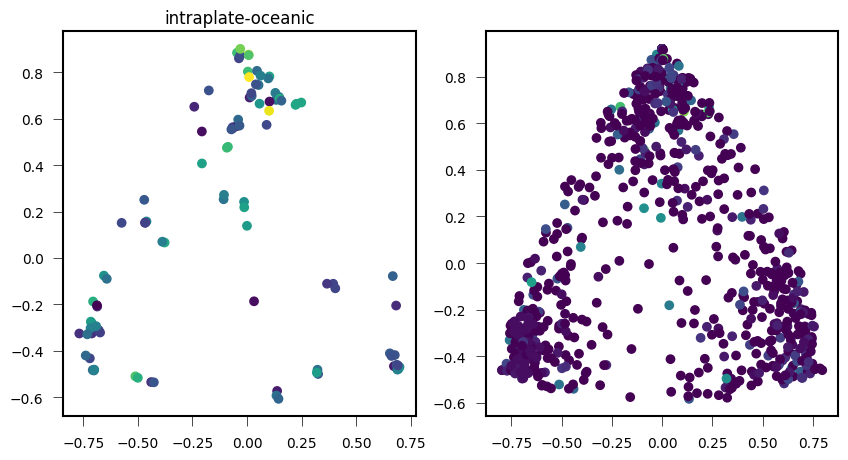

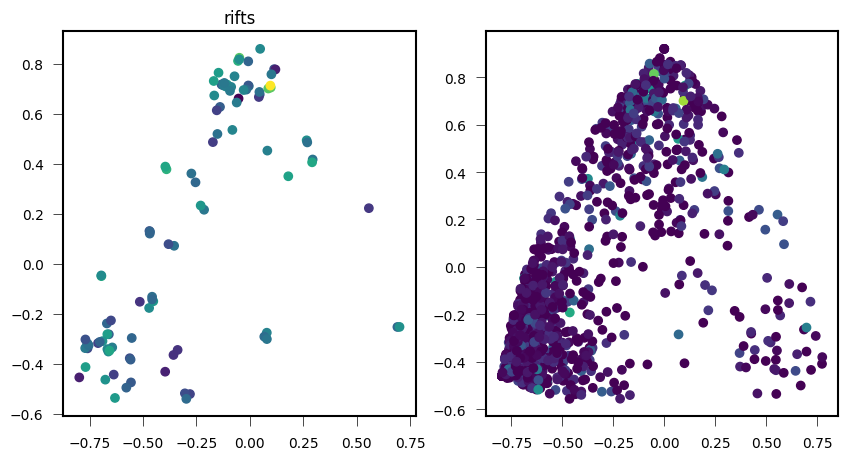

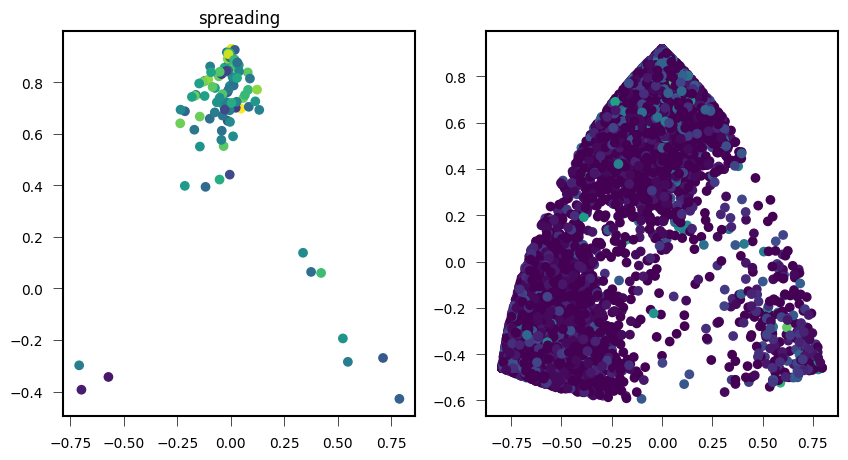

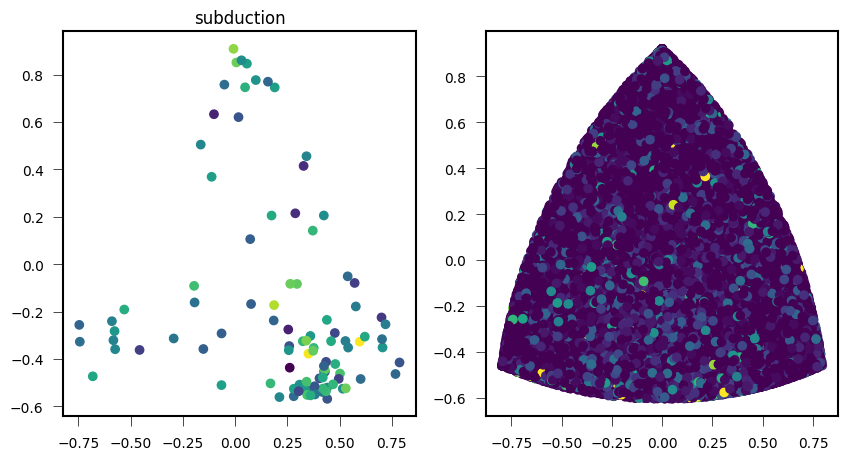

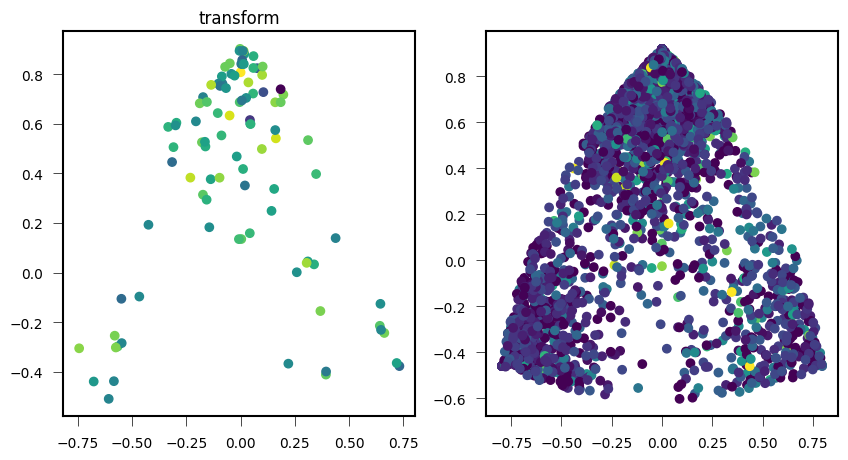

In [93]:
for type, data in new_quakes.groupby('type'):
    fig = plt.figure(figsize=(10,5))
    grid = fig.add_gridspec(1, 2)
    ax = fig.add_subplot(grid[0, 0])
    ax.scatter(data.x_kav, data.y_kav, c=data.ms)
    ax.set_title(type)
    ax = fig.add_subplot(grid[0, 1])
    ax.scatter(quakes_tec[type].x_kav, quakes_tec[type].y_kav, c=quakes_tec[type].MS, vmin=data.ms.min(), vmax=data.ms.max())

Scalar Moment [Nm]: M0 = 1.22474 (Mw = -6.0)
Moment Tensor [Nm]: Mnn =  1.000,  Mee =  1.000, Mdd =  1.000,
                    Mne =  0.000,  Mnd =  0.000, Med =  0.000    [ x 1 ]
Fault plane 1 [deg]: strike = 270, dip =  45, slip-rake =   90
Fault plane 2 [deg]: strike =  90, dip =  45, slip-rake =   90
 Year                            1976
Month                              4
Day                               22
Time                      17:03:07.9
Latitude                       28.71
Longitude                      52.13
Depth                           24.0
mb                               6.0
MS                               5.5
Region                  SOUTHERNIRAN
CMT Name                    C042276A
CMT Time                         2.7
T Err                            0.4
CMT Lat                        28.49
Lat Err                         0.05
CMT Lon                        52.08
Lon Err                         0.03
CMT Depth                       15.0
Depth Err                 

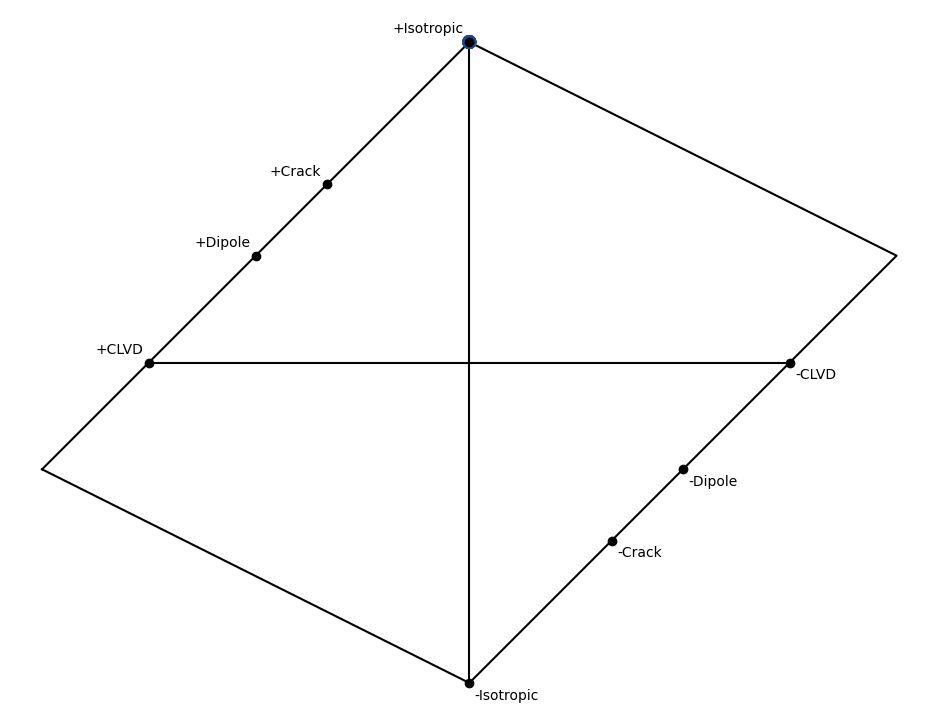

In [20]:
from pyrocko.plot import hudson, beachball, mpl_init, mpl_color
from pyrocko import moment_tensor as pmt

import sys
module_path = '/staff/quentin/Documents/Codes/FMC-master/'
sys.path.append(module_path)

# a bunch of random MTs
moment_tensors = [pmt.MomentTensor(**dict(mdd=mt.Mrr, mnn=mt.Mtt, mee=mt.Mpp, mnd=mt.Mrt, med=-mt.Mrp, mne=-mt.Mtp, scalar_moment=pmt.magnitude_to_moment(mt.MS))) for _, mt in quakes_tec['collision'].iterrows()]
moment_tensors = [pmt.MomentTensor(**dict(mdd=1, mnn=1, mee=1, mnd=0, med=-0, mne=-0, scalar_moment=pmt.magnitude_to_moment(mt.MS))) for _, mt in quakes_tec['collision'].iterrows()]
moment_tensors = moment_tensors[:10]

print(moment_tensors[0], quakes_tec['collision'].iloc[0])

# setup plot layout
fontsize = 10.
markersize = fontsize
mpl_init(fontsize=fontsize)
width = 10.
figsize = (width, width / (4. / 3.))
fig = plt.figure(figsize=figsize)
axes = fig.add_subplot(1, 1, 1)
fig.subplots_adjust(left=0.03, right=0.97, bottom=0.03, top=0.97)

# draw focal sphere diagrams for the random MTs
for mt in moment_tensors:
    u, v = hudson.project(mt)
    try:
        beachball.plot_beachball_mpl(
            mt, axes,
            beachball_type='full',
            position=(u, v),
            size=markersize,
            color_t=mpl_color('skyblue3'),
            color_p=mpl_color('skyblue1'),
            alpha=1.0,  # < 1 for transparency
            zorder=1,
            linewidth=1e-3)

    except beachball.BeachballError as e:
        print(str(e), file=sys.stderr)
        
# draw the axes and annotations of the hudson plot
hudson.draw_axes(axes)

In [ ]:
import seaborn as sns
type_eq = 'subduction'
#sns.histplot(data=quakes_tec[type_eq], x='Mtt', color='blue')
unknown = 'Rake 1'
sns.histplot(data=quakes_tec[type_eq].loc[(quakes_tec[type_eq].MS>4)&((quakes_tec[type_eq]['Dip 1']-25)<20)], x=unknown, color='orange')

# Earth map

In [ ]:
ZONE_TYPES = EARTH_ZONES["zone_type"].unique()
COLORS_ZONES = ["120/94/240", "220/38/127", "254/97/0", "247/230/20", "255/176/0"]


fig = pygmt.Figure()
pygmt.config(FONT="11p")
pygmt.config(FONT="Helvetica")
fig.basemap(region="g", projection="N0/15c", frame=["fa60","+g100/143/255"])

fig.plot(data=OC_POL, fill="240/240/240" ) 

for i,zone in enumerate(ZONE_TYPES):
    fig.plot(data=EARTH_ZONES[EARTH_ZONES.zone_type==zone], fill=COLORS_ZONES[i])

fig.show(dpi=1000, width=1000)

fig.savefig("map_Earth.png",       dpi=1000)


# Venus map

In [ ]:

fig = pygmt.Figure()
pygmt.config(FONT="11p")
pygmt.config(FONT="Helvetica")

fig.basemap(region="g", projection="N0/15c", frame=["fa60","+g240/240/240"])

fig.plot(data=VENUS_RIFTS,  fill="254/97/0")
fig.plot(data=VENUS_CORONA, fill="220/38/127")
fig.plot(data=VENUS_RIDGES, fill="120/94/240")

fig.show(dpi=1000, width=1000)

fig.savefig("map_Venus.png",       dpi=1000)

# Earthquakes map

In [ ]:
ZONE_TYPES = EARTH_ZONES["zone_type"].unique()
COLORS_ZONES = ["120/94/240", "220/38/127", "254/97/0", "247/230/20", "255/176/0", "100/143/255", "85/210/201"]

fig = pygmt.Figure()
pygmt.config(FONT="11p")
pygmt.config(FONT="Helvetica")
fig.basemap(region="g", projection="N0/15c", frame=["fa60","+g178/200/249"])

fig.plot(data=OC_POL, fill="240/240/240") 

for i, k in enumerate(settings):
    fig.plot(x=quakes_tec[k].Longitude, 
             y=quakes_tec[k].Latitude,
             fill=COLORS_ZONES[i],
             size=0.07*(((np.log10(quakes_tec[k].Moment)-9.05)/1.5)-4),
             style="cc",
             pen="black")

fig.show(dpi=500, width=1000)

fig.savefig("map_Earth_seismicity_tectonic_setting.png",       dpi=1000)


In [34]:
os.chdir('/staff/quentin/Documents/Codes/FMC-master/')
template_FMC = f"./FMC.py -p 'test.png' collision_FMC.dat -pc fclvd"
os.system(template_FMC)

0